# Music EDA — EMOPIA & MAESTRO

Exploratory Data Analysis notebook for EMOPIA (emotion-labeled MIDI) and MAESTRO (piano MIDI).

In [1]:
# Imports & device
import os
from pathlib import Path
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pretty_midi
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
print('imports ok')

imports ok


In [2]:
# Configuration: adjust paths if needed
BASE = Path('/Users/anneshanaskar/PERSONAL DRIVE/MDS/5mds/Project/Project Codes')
EMOPIA_LABEL = BASE / 'EMOPIA_1.0' / 'label.csv'
EMOPIA_META = BASE / 'EMOPIA_1.0' / 'metadata_by_song.csv'
EMOPIA_MIDI_DIR = BASE / 'EMOPIA_1.0' / 'midis'
MAESTRO_CSV = BASE / 'maestro-v3.0.0.csv'
MAESTRO_MIDI_DIR = BASE / 'maestro-v3.0.0'

# Limits for faster runs
SAMPLE_LIMIT = 300  # per-source sample for stats / plots

print('CONFIG:')
print(' EMOPIA_LABEL:', EMOPIA_LABEL.exists())
print(' EMOPIA_MIDI_DIR:', EMOPIA_MIDI_DIR.exists())
print(' MAESTRO_CSV:', MAESTRO_CSV.exists())
print(' MAESTRO_MIDI_DIR:', MAESTRO_MIDI_DIR.exists())

CONFIG:
 EMOPIA_LABEL: True
 EMOPIA_MIDI_DIR: True
 MAESTRO_CSV: True
 MAESTRO_MIDI_DIR: True


In [3]:
# Safe metadata loading
def safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception as e:
        print('Could not read', p, e)
        return None

emopia_labels = safe_read_csv(EMOPIA_LABEL)
emopia_meta = safe_read_csv(EMOPIA_META)
maestro_df = safe_read_csv(MAESTRO_CSV)

print('Loaded metadata:')
print(' emopia_labels:', None if emopia_labels is None else len(emopia_labels))
print(' emopia_meta:', None if emopia_meta is None else len(emopia_meta))
print(' maestro_df:', None if maestro_df is None else len(maestro_df))

Loaded metadata:
 emopia_labels: 1078
 emopia_meta: 387
 maestro_df: 1276


In [4]:
# MIDI -> sequence converter (same features used in main notebook)
def midi_to_sequence(midi_path, max_length=512, min_pitch=21, max_pitch=108):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        notes = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append({
                    'pitch': note.pitch,
                    'velocity': note.velocity,
                    'start': note.start,
                    'end': note.end,
                    'duration': note.end - note.start
                })
        if len(notes) == 0:
            return None, False
        notes.sort(key=lambda x: x['start'])
        sequence = []
        prev_time = 0.0
        for note in notes[:max_length]:
            pitch = np.clip((note['pitch'] - min_pitch) / (max_pitch - min_pitch), 0, 1)
            velocity = note['velocity'] / 127.0
            duration = min(note['duration'], 4.0) / 4.0
            time_offset = min(note['start'] - prev_time, 2.0) / 2.0
            sequence.append([pitch, velocity, duration, time_offset])
            prev_time = note['start']
        if len(sequence) < max_length:
            padding = [[0, 0, 0, 0]] * (max_length - len(sequence))
            sequence.extend(padding)
        else:
            sequence = sequence[:max_length]
        return np.array(sequence, dtype=np.float32), True
    except Exception as e:
        # print('midi_to_sequence error:', midi_path, e)
        return None, False

In [6]:
# Collect MIDI file lists (limited)
# ...existing code...
def collect_emopia(mididir, labels_df):
    files = []
    emotions = []
    if labels_df is None:
        return files, emotions
    for _, row in labels_df.iterrows():
        midi_file = mididir / f"{row['ID']}.mid"
        if midi_file.exists():
            files.append(str(midi_file))
            emotions.append(row.get('4Q', np.nan))
    return files, emotions

def collect_maestro(maestro_df, midi_dir):
    files = []
    if maestro_df is None:
        return files
    # prefer train split if present
    if 'split' in maestro_df.columns:
        df = maestro_df[maestro_df['split']=='train']
    else:
        df = maestro_df
    for _, row in df.iterrows():
        midi_file = midi_dir / row['midi_filename']
        if midi_file.exists():
            files.append(str(midi_file))
    return files
# ...existing code...

emopia_files, emopia_emotions = collect_emopia(EMOPIA_MIDI_DIR, emopia_labels)
maestro_files = collect_maestro(maestro_df, MAESTRO_MIDI_DIR)

# apply caps
emopia_files = emopia_files[:SAMPLE_LIMIT]
emopia_emotions = emopia_emotions[:len(emopia_files)]
maestro_files = maestro_files[:SAMPLE_LIMIT]

print('Found (sampled):', len(emopia_files), 'EMOPIA,', len(maestro_files), 'MAESTRO')

Found (sampled): 300 EMOPIA, 300 MAESTRO


In [8]:
# Per-file MIDI statistics
def midi_stats(midi_path, use_seq=True, max_len=512):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
    except Exception:
        return None
    notes = []
    for inst in pm.instruments:
        for n in inst.notes:
            notes.append(n)
    n_notes = len(notes)
    duration = pm.get_end_time()
    avg_pitch = float(np.mean([n.pitch for n in notes])) if n_notes > 0 else np.nan
    pitch_std = float(np.std([n.pitch for n in notes])) if n_notes > 0 else np.nan
    seq_len = None
    if use_seq:
        seq, valid = midi_to_sequence(midi_path, max_length=max_len)
        if valid and seq is not None:
            # count non-padding rows (rows that are not all zeros)
            # use np.isclose + np.all over axis to avoid passing invalid 'axis' to np.allclose
            nonzero_rows = ~np.all(np.isclose(seq, 0.0, atol=1e-6), axis=1)
            seq_len = int(nonzero_rows.sum())
    return {
        'path': str(midi_path),
        'n_notes': n_notes,
        'duration': duration,
        'avg_pitch': avg_pitch,
        'pitch_std': pitch_std,
        'seq_len': seq_len
    }

def compute_stats_for_list(files, desc='files', sample_limit=200):
    rows = []
    for f in tqdm(files[:sample_limit], desc='Computing '+desc):
        s = midi_stats(f)
        if s is not None:
            rows.append(s)
    return pd.DataFrame(rows)

emopia_stats = compute_stats_for_list(emopia_files, 'EMOPIA', sample_limit=SAMPLE_LIMIT)
maestro_stats = compute_stats_for_list(maestro_files, 'MAESTRO', sample_limit=SAMPLE_LIMIT)

print('Computed stats shapes:', emopia_stats.shape, maestro_stats.shape)

Computing MAESTRO: 100%|██████████| 300/300 [00:58<00:00,  5.13it/s]

Computed stats shapes: (300, 6) (300, 6)


EMOPIA 4Q distribution (sample):


1    250
2     50
Name: count, dtype: int64

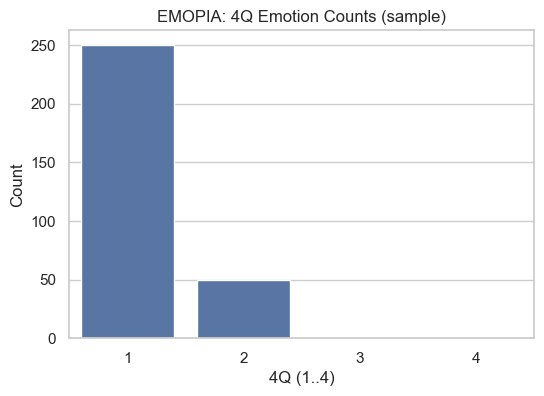

\nMAESTRO split counts (full metadata):


split
train         962
test          177
validation    137
Name: count, dtype: int64

In [9]:
# Visualizations: emotion distribution & split counts
if emopia_emotions:
    emo_series = pd.Series([int(e) for e in emopia_emotions if not pd.isna(e)])
    print('EMOPIA 4Q distribution (sample):')
    display(emo_series.value_counts().sort_index())
    plt.figure(figsize=(6,4))
    sns.countplot(x=emo_series.astype(str), order=[str(i) for i in range(1,5)])
    plt.title('EMOPIA: 4Q Emotion Counts (sample)')
    plt.xlabel('4Q (1..4)')
    plt.ylabel('Count')
    plt.show()
else:
    print('No EMOPIA emotion labels available (sample).')

if maestro_df is not None and 'split' in maestro_df.columns:
    print('\\nMAESTRO split counts (full metadata):')
    display(maestro_df['split'].value_counts())
else:
    print('\\nMAESTRO split metadata not available.')

,count,mean,std,min,25%,50%,75%,max
n_notes,300.0,304.186667,133.389835,49.000000,209.000000,275.000000,378.250000,901.000000
duration,300.0,35.516641,9.223306,18.009115,29.989583,36.729167,39.989583,74.998698
avg_pitch,300.0,62.244187,4.789629,50.330189,59.250448,62.685834,65.283140,77.426606
pitch_std,300.0,13.123262,2.660332,6.388906,11.386734,12.974204,14.899779,21.420492
seq_len,300.0,296.910000,113.407699,49.000000,209.000000,275.000000,378.250000,512.000000


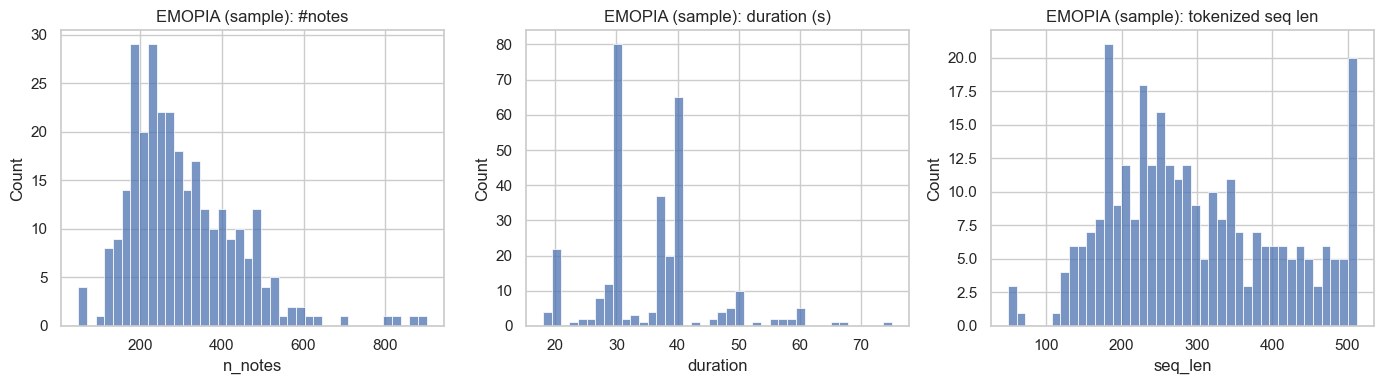

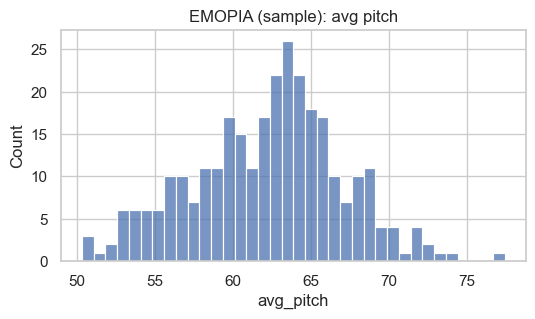

,count,mean,std,min,25%,50%,75%,max
n_notes,300.0,6208.546667,4016.123518,405.000000,3152.500000,5466.500000,7623.750000,20290.000000
duration,300.0,584.640519,402.450430,78.312500,297.896159,536.570312,708.552409,2463.480469
avg_pitch,300.0,65.246130,4.400040,56.359213,62.889478,64.692689,67.495714,77.367489
pitch_std,300.0,13.492278,2.350134,8.182394,11.507003,13.189473,15.728182,18.491024
seq_len,300.0,511.643333,6.177648,405.000000,512.000000,512.000000,512.000000,512.000000


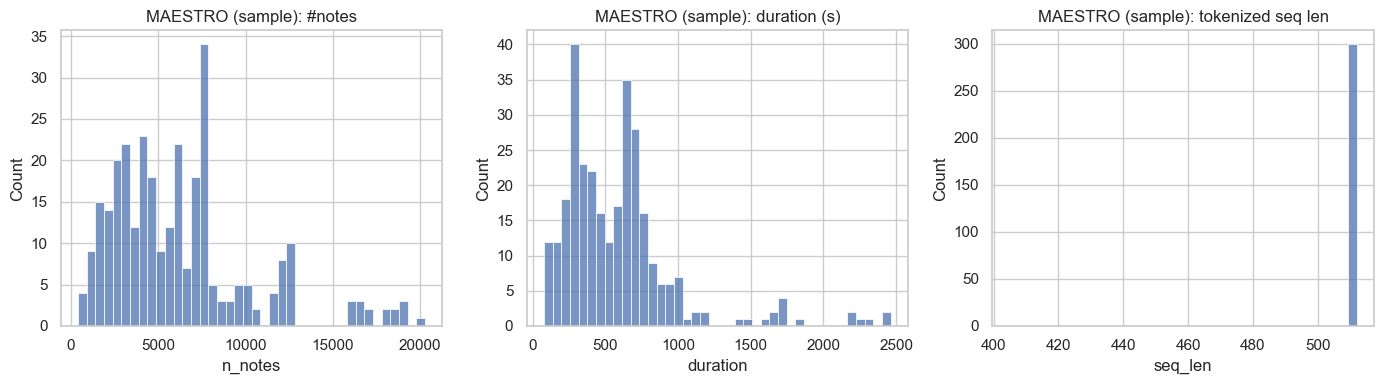

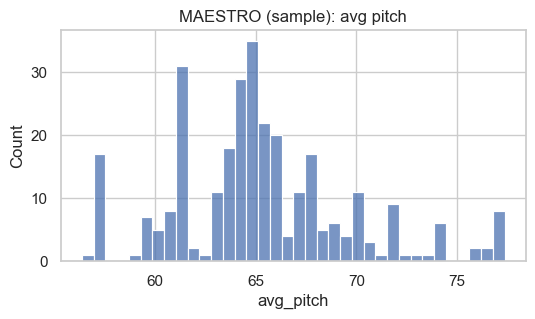

In [10]:
# Numeric distributions: n_notes, duration, seq_len, avg_pitch
def plot_numeric(df, name):
    if df.empty:
        print('No stats for', name)
        return
    display(df.describe().T)
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    sns.histplot(df['n_notes'].dropna(), bins=40)
    plt.title(f'{name}: #notes')
    plt.subplot(1,3,2)
    sns.histplot(df['duration'].dropna(), bins=40)
    plt.title(f'{name}: duration (s)')
    plt.subplot(1,3,3)
    if 'seq_len' in df.columns:
        sns.histplot(df['seq_len'].dropna(), bins=40)
        plt.title(f'{name}: tokenized seq len')
    plt.tight_layout()
    plt.show()
    if 'avg_pitch' in df.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(df['avg_pitch'].dropna(), bins=36)
        plt.title(f'{name}: avg pitch')
        plt.show()

plot_numeric(emopia_stats, 'EMOPIA (sample)')
plot_numeric(maestro_stats, 'MAESTRO (sample)')

Counting EMOPIA: 100%|██████████| 100/100 [00:00<00:00, 363.28it/s]



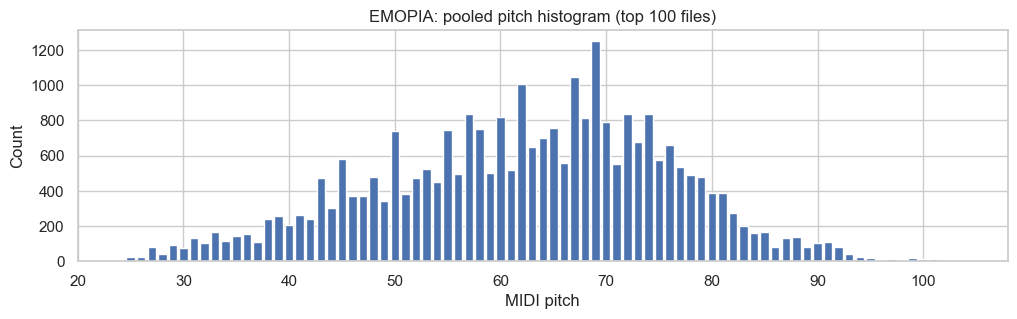

Counting MAESTRO: 100%|██████████| 100/100 [00:07<00:00, 13.36it/s]



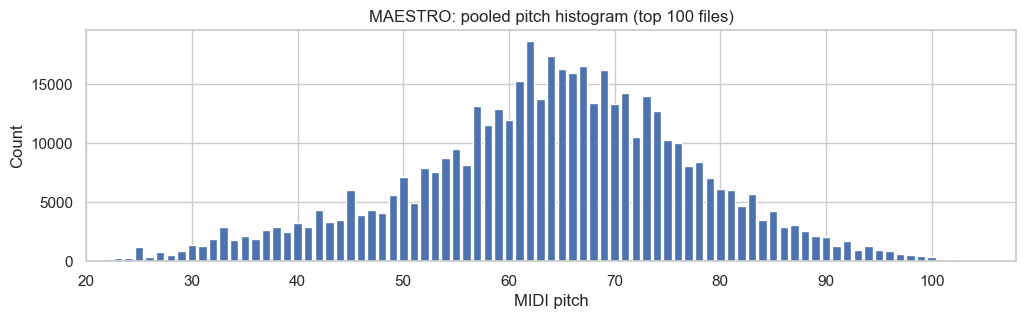

In [11]:
# Pooled pitch histogram across sample files
def pooled_pitch_hist(files, name, top_files=100):
    pitch_counts = np.zeros(128, dtype=int)
    for f in tqdm(files[:top_files], desc='Counting '+name):
        try:
            pm = pretty_midi.PrettyMIDI(f)
            for inst in pm.instruments:
                for n in inst.notes:
                    p = int(n.pitch)
                    if 0 <= p < 128:
                        pitch_counts[p] += 1
        except Exception:
            continue
    plt.figure(figsize=(12,3))
    plt.bar(np.arange(128), pitch_counts)
    plt.xlim(20,108)
    plt.title(f'{name}: pooled pitch histogram (top {min(top_files,len(files))} files)')
    plt.xlabel('MIDI pitch')
    plt.ylabel('Count')
    plt.show()

pooled_pitch_hist(emopia_files, 'EMOPIA')
pooled_pitch_hist(maestro_files, 'MAESTRO')

EMOPIA example:


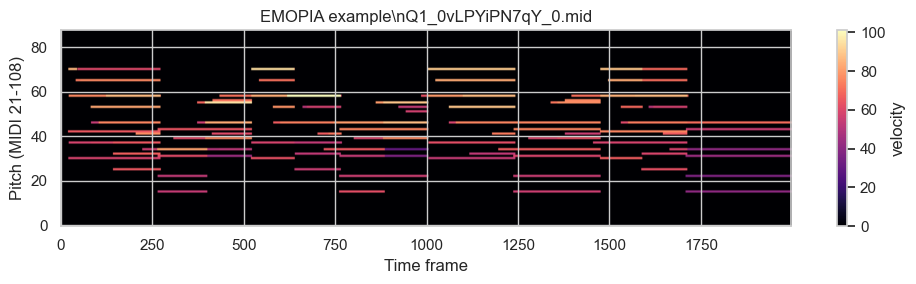

MAESTRO example:


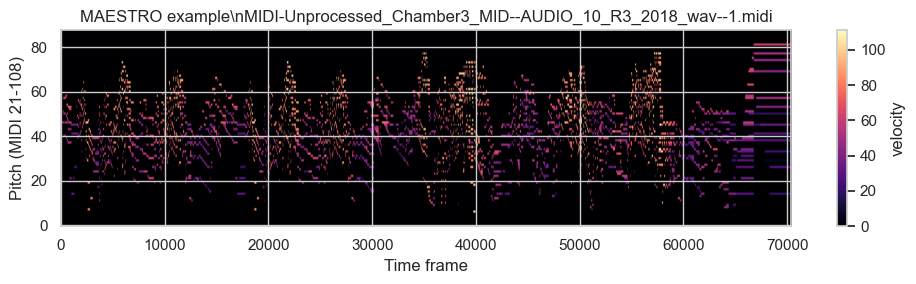

In [12]:
# Piano-roll for one example each
def show_pianoroll(midi_path, title='piano-roll', fs=100):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
    except Exception as e:
        print('Could not load', midi_path, e)
        return
    pr = pm.get_piano_roll(fs=fs)
    pr = pr[21:109,:]  # piano range
    plt.figure(figsize=(10,3))
    plt.imshow(pr, aspect='auto', origin='lower', cmap='magma')
    plt.title(f'{title}\\n{Path(midi_path).name}')
    plt.xlabel('Time frame')
    plt.ylabel('Pitch (MIDI 21-108)')
    plt.colorbar(label='velocity')
    plt.tight_layout()
    plt.show()

if emopia_files:
    print('EMOPIA example:')
    show_pianoroll(emopia_files[0], title='EMOPIA example')
if maestro_files:
    print('MAESTRO example:')
    show_pianoroll(maestro_files[0], title='MAESTRO example')

In [13]:
# Tokenized / sequence preview for a sample file
print('Sample previews:')
for src_name, files in [('EMOPIA', emopia_files), ('MAESTRO', maestro_files)]:
    if not files:
        continue
    f = files[0]
    print(f'\\n{src_name} sample: {Path(f).name}')
    seq, valid = midi_to_sequence(f, max_length=64)
    if valid:
        print(' sequence shape:', seq.shape)
        print(' first 8 events (pitch,vel,dur,offset):')
        print(np.round(seq[:8], 4))
    else:
        print(' midi_to_sequence failed for sample')

Sample previews:
\nEMOPIA sample: Q1_0vLPYiPN7qY_0.mid
 sequence shape: (64, 4)
 first 8 events (pitch,vel,dur,offset):
[[0.4828 0.5118 0.6331 0.0983]
 [0.3448 0.4567 0.6296 0.0033]
 [0.8046 0.6772 0.0605 0.002 ]
 [0.6667 0.5984 0.099  0.0033]
 [0.4253 0.4567 0.1491 0.    ]
 [0.7471 0.5748 0.0306 0.097 ]
 [0.8046 0.4724 0.5654 0.0247]
 [0.7471 0.5984 0.5459 0.0391]]
\nMAESTRO sample: MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
 sequence shape: (64, 4)
 first 8 events (pitch,vel,dur,offset):
[[0.5287 0.4094 0.2067 0.4915]
 [0.5862 0.5276 0.0306 0.4004]
 [0.6552 0.5118 0.3633 0.1816]
 [0.5747 0.3543 0.5426 0.0033]
 [0.4598 0.3071 0.2663 0.0124]
 [0.5287 0.3071 0.2448 0.0013]
 [0.6667 0.4567 0.0801 0.959 ]
 [0.6667 0.5433 0.0973 0.3229]]


In [14]:
# Save summaries and figures (optional)
OUT = BASE / 'eda_outputs'
OUT.mkdir(exist_ok=True)
try:
    emopia_stats.to_csv(OUT / 'emopia_stats_sample.csv', index=False)
    maestro_stats.to_csv(OUT / 'maestro_stats_sample.csv', index=False)
    print('Saved CSV summaries to', OUT)
except Exception as e:
    print('Could not save CSV summaries:', e)

Saved CSV summaries to /Users/anneshanaskar/PERSONAL DRIVE/MDS/5mds/Project/Project Codes/eda_outputs


End of EDA notebook. Adjust SAMPLE_LIMIT and paths at top as needed.